## Custom LangGraph Agent

Now, we'll do the same as shown above. But rather than following the ReAct agent control flow, we'll use a custom control flow.

Here we'll explicitly define the majority of the control flow, only using an LLM to define a single branch point following grading.

![](../static/5.png)

First, we'll define a RAG chain to produce our final answer.


## Environment

We'll start with [OpenAI](https://python.langchain.com/v0.2/docs/integrations/chat/openai/) as our LLM, but this can be easily swapped. 

We'll use [Tavily](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/) for web search.

We'll use a vectorstore with [OpenAI embeddings](https://python.langchain.com/v0.2/docs/integrations/text_embedding/openai/#embed-documents).

We'll use [LangSmith](https://docs.smith.langchain.com/) for tracing and evaluation.

In [ ]:
import os

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Access environment variables
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

# Check if required environment variables are set
required_vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "TAVILY_API_KEY"]
for var in required_vars:
    if not os.getenv(var):
        raise EnvironmentError(f"{var} is not set in the .env file")

print("Environment variables loaded successfully.")

## LLM

Select the LLM to use for both of our agents.

This can be easily swapped with [other models that support tool use](https://python.langchain.com/v0.2/docs/integrations/chat/)!

In [ ]:
from langchain_openai import ChatOpenAI

model_name = "gpt-4o"
metadata = "CRAG, gpt-4o"
llm = ChatOpenAI(model_name=model_name, temperature=0)

In [ ]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)

rag_chain = prompt | llm | StrOutputParser()

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_core.tools import tool
from langchain_openai import OpenAIEmbeddings

# List of URLs to load documents from
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents from the URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter with specified chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=250, chunk_overlap=0)

# Split the documents into chunks
doc_splits = text_splitter.split_documents(docs_list)

# Add the document chunks to the "vector store" using OpenAIEmbeddings
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever(k=4)

USER_AGENT environment variable not set, consider setting it to identify your requests.


Now, we'll define a document grader to review our documents.


In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field


# Data model for the output
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")


# LLM with tool call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a teacher grading a quiz. You will be given: 
1/ a QUESTION 
2/ a set of comma separated FACTS provided by the student

You are grading RELEVANCE RECALL:
A score of 1 means that ANY of the FACTS are relevant to the QUESTION. 
A score of 0 means that NONE of the FACTS are relevant to the QUESTION. 
1 is the highest (best) score. 0 is the lowest score you can give. 

Explain your reasoning in a step-by-step manner. Ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "FACTS: \n\n {documents} \n\n QUESTION: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

Finally, we'll define our graph.

Before, our state was a set of messages.

Here, our state is a dict of specific entities that we want to persist.


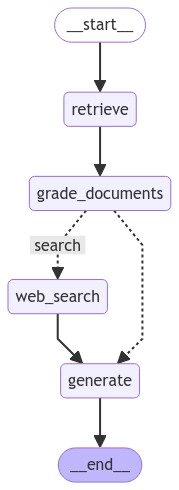

In [ ]:
from typing import Annotated, List

from IPython.display import Image, display
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import END, START, StateGraph
from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: The question being asked.
        generation: The generated answer from the LLM.
        search: Indicates whether to add search functionality.
        documents: List of documents retrieved.
        steps: List of actions taken in the process, such as 'retrieve_documents' and 'generate_answer'.
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "documents": d.page_content})
        grade = score.binary_score
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    web_search_tool = TavilySearchResults()

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend([Document(page_content=d["content"], metadata={"url": d["url"]}) for d in web_results])
    return {"documents": documents, "question": question, "steps": steps}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"


# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
import uuid


def predict_custom_agent_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state_dict = custom_graph.invoke({"question": example["input"], "steps": []}, config)
    return {"response": state_dict["generation"], "steps": state_dict["steps"]}


example = {"input": "What are the types of agent memory?"}
response = predict_custom_agent_answer(example)
response

{'response': 'The types of agent memory are short-term memory and long-term memory. Short-term memory involves in-context learning, while long-term memory allows the agent to retain and recall information over extended periods, often using an external vector store for fast retrieval. Additionally, there is a memory stream, which is a long-term memory module that records a comprehensive list of the agent’s experiences in natural language.',
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'web_search',
  'generate_answer']}

We can see from our trace that our agent follows the specified control flow:

https://smith.langchain.com/public/7f14c989-4505-4bc1-9c87-9126899f8714/r
